In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow

import matplotlib.pyplot as plt
%matplotlib inline

import os

In [132]:
directory = '/tmp/sgld16/'

In [97]:
def plot_densities(data, n_indices, n_bins, alpha, delta=None, burnin=10):
    n = data.shape[0]
    indices = np.linspace(burnin, n-1, n_indices).astype(int)
    toplot = []
    for start, stop in zip(indices[:-1], indices[1:]):
        toplot.append(data[start:stop])
    color_idx = np.linspace(0, 1, n_indices)
    mn = np.infty
    mx = 0 
    mean = 0
    if delta is None:
        for thisdata in toplot:
            newmin = np.min(thisdata)
            newmax = np.max(thisdata)
            if newmin < mn: mn = newmin
            if newmax > mx: mx = newmax
    else:
        for thisdata in toplot:
            mean += np.mean(thisdata)
        mean = mean/len(toplot)
        mn = mean - delta/2
        mx = mean + delta/2
        
    for ci, thisdata in zip(color_idx, toplot):
        x, y = np.histogram(thisdata, range = (mn, mx), bins=n_bins)
        plt.plot(y[:-1], x, color=plt.cm.RdBu(ci), alpha=alpha)
        
    plt.xlabel('value')
    plt.ylabel('count')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdBu)
    sm._A = []
    cbar = plt.colorbar(sm, ticks = [0.1, .9])
    cbar.ax.set_yticklabels(['early', 'late'])
    plt.show()
    
    return mx - mn

In [98]:
def analyse_directory(directory, stdev_n_from_last=100, delta = 20):
    modelnames = {'.'.join(fname.split('.')[:2]) for fname in os.listdir(directory) if fname[:5] == 'model'}
    mn = list(sorted(modelnames, key=lambda x: int(x.split('-')[-1])))
    histo = []
    model_file = directory + mn[0]
    reader = pywrap_tensorflow.NewCheckpointReader(model_file)
    var_to_shape_map = reader.get_variable_to_shape_map()
    valid_keys = []
    for key in var_to_shape_map:
        if (key[:3] == 'con' or key[:3] == 'den') and len(key.split('/')) ==2:
            valid_keys.append(key)
    print(valid_keys)
    
    for chkpt in mn:
        model_file = directory + chkpt
        reader = pywrap_tensorflow.NewCheckpointReader(model_file)
        model_vector = []
        for key in valid_keys:
            model_vector.append(reader.get_tensor(key).ravel())

        out = np.hstack(model_vector)
        histo.append(out)
    histo = np.vstack(histo)
    print('hist shape: ', histo.shape)
    
    stdevs = np.std(histo[-stdev_n_from_last:], axis=0)
    print('max std ', np.max(stdevs))
    
    return histo, stdevs

In [14]:
histo, stdevs = analyse_directory('/tmp/tf/distrib_sgd/')

['dense_1/kernel', 'dense_1/bias', 'dense/bias', 'conv2d/bias', 'conv2d/kernel', 'conv2d_1/kernel', 'conv2d_1/bias', 'dense/kernel']
hist shape:  (1007, 3274634)
max std  0.00164929


In [11]:
histo2, stdevs2 = analyse_directory('/tmp/tf/distrib_sgld/')

['conv2d/bias', 'conv2d_1/bias', 'conv2d/kernel', 'dense/bias', 'dense/kernel', 'dense_1/bias', 'conv2d_1/kernel', 'dense_1/kernel']
hist shape:  (1008, 3274634)
max std  0.00211776


In [12]:
histo3, stdevs3 = analyse_directory('/tmp/tf/distrib_psgld/')

['conv2d_1/bias', 'conv2d/kernel', 'conv2d/bias', 'dense/bias', 'dense/kernel', 'conv2d_1/kernel', 'dense_1/kernel', 'dense_1/bias']
hist shape:  (1008, 3274634)
max std  0.00194608


In [81]:
histo4, stdevs4 = analyse_directory('/tmp/tf/distrib_ksgld/')

['dense_1/bias', 'dense/kernel', 'dense/bias', 'dense_1/kernel', 'conv2d_1/kernel', 'conv2d/bias', 'conv2d/kernel', 'conv2d_1/bias']
hist shape:  (1015, 3274634)
max std  0.00184944


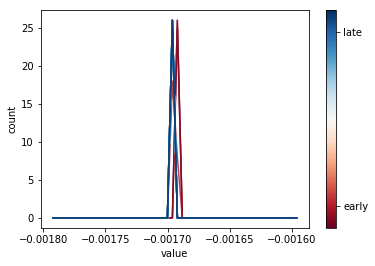

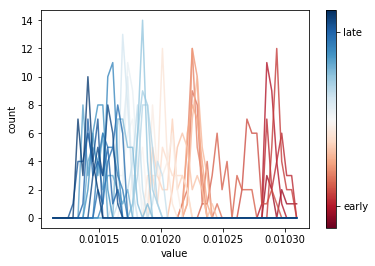

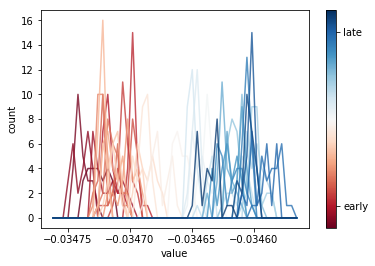

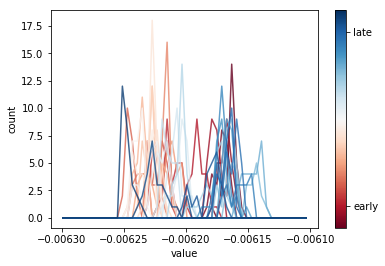

0.00020000000000000052

In [106]:
i = 8000
a, b = 40, 50
delta = 0.0002
plot_densities(histo[:,i],a,b,.8, burnin=0, delta=delta)
plt.show()
plot_densities(histo2[:,i],a,b,.8, burnin=0, delta=delta)
plt.show()
plot_densities(histo3[:,i],a,b,.8, burnin=0, delta=delta)
plt.show()
plot_densities(histo4[:,i],a,b,.8, burnin=0, delta=delta)

In [83]:
def plot_std(delta, data, index):
    indices = np.arange(0, data.shape[0] -1, delta)
    stdevs = []
    for start, stop in zip(indices[:-1], indices[1:]):
        stdevs.append(np.std(data[start:stop, index]))
        
    return stdevs

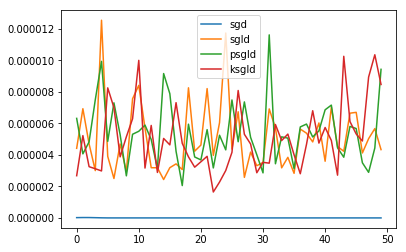

In [85]:
i = 8000
plt.plot(plot_std(20, histo, i), label='sgd' )
plt.plot(plot_std(20, histo2, i), label='sgld' )
plt.plot(plot_std(20, histo3, i), label='psgld' )
plt.plot(plot_std(20, histo4, i), label='ksgld' )
plt.legend()

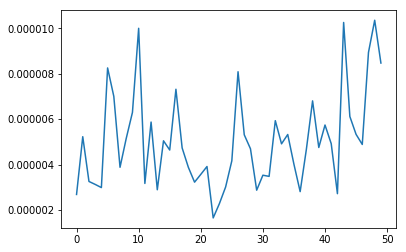

In [86]:
plt.plot(plot_std(20, histo4, i), label='ksgld' )

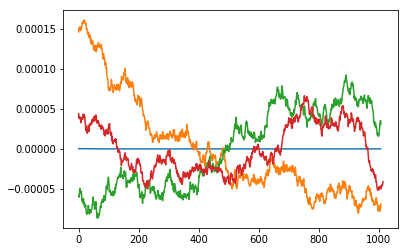

In [87]:
i = 8000
plt.plot(histo[:, i]-np.mean(histo[:, i]))
plt.plot(histo2[:, i]-np.mean(histo2[:, i]))
plt.plot(histo3[:, i]-np.mean(histo3[:, i]))
plt.plot(histo4[:, i]-np.mean(histo4[:, i]))